# Data Loading 

In [2]:
!pip install cmapy


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import os
import random
import numpy as np
import cv2
import pandas as pd
import torch
import librosa
from tqdm import tqdm
from matplotlib import pyplot as plt
import librosa.display
import cmapy
import io
import math
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
import torchvision.transforms.functional as F
from torchvision import utils
from torch.utils.data import random_split
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader
import librosa
from tqdm import tqdm
import librosa.display
from utils import *






# Helper Functions

In [4]:
import os
import random
import numpy as np
import cv2
import pandas as pd
import torch
import librosa
from tqdm import tqdm
from matplotlib import pyplot as plt
import librosa.display
import cmapy
import io
import math
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
import torchvision.transforms.functional as F
from torchvision import utils
from torch.utils.data import random_split
import torchaudio

def get_annotation_data(file_name,data_dir): # Function returns the recording_data and the annotation_data
  '''
  Parameters
  ----------
  file_name: the file name of which data is to be retrived
  data_dir: Directory where file is present
  '''
  annotation_data = pd.read_csv(os.path.join(data_dir,file_name+".txt"),sep="\t")
  annotation_data.columns = ["start","end","crackle","wheeze"]
  file_data = file_name.split("_")
  recording_data = pd.DataFrame([file_data],columns = ["pid","recording_index","chest_location","acquisition_mode","equipment"])
  return recording_data,annotation_data 


def save_images(image, train_flag):
    save_dir = 'dump_image'
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
        
    if train_flag:
        save_dir = os.path.join(save_dir, 'train')
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        cv2.imwrite(os.path.join(save_dir, image[1]+'_'+str(image[2])+'_'+str(image[3])+'_'+str(image[4])+'.jpg'), cv2.cvtColor(image[0], cv2.COLOR_RGB2BGR))
    else:
        save_dir = os.path.join(save_dir, 'test')
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        cv2.imwrite(os.path.join(save_dir, image[1]+'_'+str(image[2])+'_'+str(image[3])+'_'+str(image[4])+'.jpg'), cv2.cvtColor(image[0], cv2.COLOR_RGB2BGR))

def get_label(crackle, wheeze):
    if crackle == 0 and wheeze == 0:
        return 0
    elif crackle == 1 and wheeze == 0:
        return 1
    elif crackle == 0 and wheeze == 1:
        return 2
    else:
        return 3

def get_samples(file_name,dataset_dir,annotation_data,sample_rate):
  samples = []
  audio_file,original_sr = torchaudio.load(os.path.join(dataset_dir,file_name+".wav"))
  audio_file = torchaudio.transforms.Resample(original_sr, sample_rate)(audio_file)
#   print("Audio Chunk shape: ",audio_file.shape)
#   print("Annotation Data: ",annotation_data)
  for i in range(len(annotation_data.index)):
        row = annotation_data.loc[i]
        # print("Row: ",row)
        start = row['start']
        # print("Start: ",start)
        end = row['end']
        crackles = row['crackle']
        wheezes = row['wheeze']
        max_ind = audio_file.shape[1]
        # print("Max Ind",max_ind) 
        # split signal
        start_ind = min(int(start * sample_rate), max_ind)
        end_ind = min(int(end * sample_rate), max_ind)
        # print("Start Ind",start_ind,"End Ind",end_ind)
        audio_chunk = audio_file[:,start_ind:end_ind]
        # print("Audio Chunk",audio_chunk.shape)
        samples.append((audio_chunk, get_label(crackles, wheezes), start,end))
  return samples

def get_train_test_names(train_test_file_names):
    '''
    Get List of file names belonging in train and test datasets
    ---------
    train_test_file_names:  txt file containing names of all samples in train
                            and test as given by ICBHI
    return: train_names,test_names
    '''
    train_test = pd.read_csv(train_test_file_names,sep="\t",header=None)
    train_names = train_test[train_test[1]=="train"]
    test_names = train_test[train_test[1]=="test"]
    return train_names,test_names





# Implementing Custom Dataloader

In [5]:
from torch.utils.data import Dataset, DataLoader

In [6]:
from torch.utils.data import Dataset
import librosa
from tqdm import tqdm
import librosa.display
import torchaudio
from utils import *

class ImageLoader(Dataset):
  def __init__(self,dataset_file,dataset_dir,train_flag=True,transform=None):
    self.input_transform = transform
    self.dataset_file = dataset_file
    self.dataset_dir = dataset_dir
    # self.dataset = pd.read_csv(os.path.join(dataset_dir,dataset_file),sep="\t",header=None)
    self.dataset = dataset_file
    self.audio_data = []
    # self.train_flag = False
    # Spectrogram parameters
    self.train_flag = train_flag
    self.sample_rate = 4000
    self.desired_length = 8
    self.n_mels = 128 #128
    self.nfft = 1024 #2048
    self.win_length = int(60/1000*self.sample_rate)
    self.hop = self.win_length//2
    self.f_max = 2000
    self.device_to_files = []  # mapping the filename to device
    # self.patient_to_device = {}
    self.patient_to_samples ={}
    self.patient_to_idx = {}

    # files = os.listdir(dataset_dir)
    failed_files=[]
    print("LOADING AUDIO FILES")
    for i,f in enumerate(tqdm(self.dataset[0])):
      # idx_0: patient_id, idx_1: recording_index, idx_2:Chest location, idx_3:A cquistation mode, idx_4: device
      tokens = f.strip().split("_")
      try:
        _,annotation_data = get_annotation_data(f,dataset_dir)
        sample_data = get_samples(f,dataset_dir,annotation_data,sample_rate=self.sample_rate)
        if tokens[0] not in self.patient_to_samples.keys():
          self.patient_to_samples[tokens[0]] = sample_data
        else:
          self.patient_to_samples[tokens[0]].extend(sample_data)
        
        if tokens[0] not in self.patient_to_idx.keys():
          self.patient_to_idx[tokens[0]] = [i]
        else:
          self.patient_to_idx[tokens[0]].append(i)
        
        
        self.audio_data.extend(sample_data)
        
      except Exception as e:
        print(e)
        failed_files.append(self.dataset.iloc[i,0])
        continue

  
  def augment_audio(self,audio):
    effects = [["lowpass", "-1", "300"],
           ["speed", "0.8"],
           ["rate", f"{self.sample_rate}"],
           ["reverb", "-w"],
           ["channels", "1"],
           ]
    if self.train_flag:
      audio,sr = torchaudio.sox_effects.apply_effects_tensor(audio, self.sample_rate, effects)
    # print(audio.shape)
    return audio
    

    # make a dict for easy indexing and loading

  def __getitem__(self, index):
    if torch.is_tensor(index):
      index = index.tolist()
    audio = self.audio_data[index][0]
    # print(audio.shape)
    # randomly augment data
    # print("Augmenting data")
    audio,_ = torchaudio.sox_effects.apply_effects_tensor(audio,self.sample_rate,effects=[["channels","1"]])
    if np.random.random() > 0.5:
      audio = self.augment_audio(audio)

    # pad the audio to desired length using 
    # print("Before padding: ",audio.shape)
    if audio.shape[1] < self.desired_length*self.sample_rate:
      audio = torch.nn.functional.pad(audio,(0,self.desired_length*self.sample_rate-audio.shape[1]))
    else:
      audio = audio[:,:self.desired_length*self.sample_rate]
    audio_mel_image = torchaudio.transforms.MelSpectrogram(sample_rate=self.sample_rate, n_fft=self.nfft, win_length=self.win_length, hop_length=self.hop, n_mels=self.n_mels, f_max=self.f_max)(audio)
    
    # blank Region Clipping
    audio_mel_image_raw = audio_mel_image.squeeze(0).numpy()
    for row in range(audio_mel_image_raw.shape[0]):
        black_percent = len(np.where(audio_mel_image_raw[row,:]==-100)[0])/len(audio_mel_image_raw[row,:])
        if black_percent > 0.80:
            break
    audio_mel_image_raw = audio_mel_image_raw[:row+1,:]

    for column in range(audio_mel_image_raw.shape[1]):
        black_percent = len(np.where(audio_mel_image_raw[:,column]==-100)[0])/len(audio_mel_image_raw[:,column])
        if black_percent > 0.90:
            break
    
    audio_mel_image_raw = audio_mel_image_raw[:,:column+1]
    audio_mel_image = torch.from_numpy(audio_mel_image_raw).unsqueeze(0)

    
    label = self.audio_data[index][1]
    audio_mel_image = torchvision.transforms.Resize((256,256))(audio_mel_image)
  
    if self.input_transform is not None:
      audio_mel_image = self.input_transform(audio_mel_image)
    
    label = torch.from_numpy(np.array(label)).float()
    return audio_mel_image,label

  def __len__(self):
    # print("Length of dataset: ",len(self.audio_data))
    return len(self.audio_data)
  

# Implementing Patient Based Tuning Model

In [7]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from utils import *

class RModel(torch.nn.Module):
    def __init__(self):
        super(RModel,self).__init__()
        self.hidden_dim = 256
        self.num_layers = 1
        self.input_dim = 128
        self.fc_dim = 36864
        self.feature_extractor = torch.nn.Sequential(
            torch.nn.BatchNorm2d(1),
            # conv layer with kernel 5x7
            torch.nn.Conv2d(1, 64, kernel_size=(5,7)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2,3)),
            torch.nn.Conv2d(64,64,kernel_size=(3,3)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,kernel_size=(3,3)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2,3)),
            torch.nn.Conv2d(64,128,kernel_size=(3,3)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,kernel_size=(3,3)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2,3)),
            torch.nn.Conv2d(128,128,kernel_size=(3,3)),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,kernel_size=(3,3)),
            torch.nn.ReLU(),
        )
        self.fully_connected = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(self.fc_dim,100),
            # torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(100,4),
            torch.nn.Softmax()
        )
        self.bi_lstm_block = torch.nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True, bidirectional=True)
    
    
    def init_hidden_state(self, batch_size,device='cuda'):
        return (torch.zeros((self.num_layers * 2, batch_size, self.hidden_dim),device=device),
                torch.zeros((self.num_layers * 2, batch_size, self.hidden_dim),device=device))

    def init_optimizer(self,learning_rate=0.0001):
        return torch.optim.Adam(self.parameters(), lr=learning_rate, amsgrad=False,betas=(0.9, 0.999), weight_decay=5e-4)
    
    def forward(self, x):
        # reshape the input to (batch_size, num_channels, height, width)
        # x = x.permute(0, 3, 2, 1)
        x = self.feature_extractor(x)
        batch_size, C, H, W = x.size()
        x = x.view(batch_size, C, H*W)
        x = x.permute(0, 2, 1)
        self.fc_dim = self.hidden_dim * H * W * 2
        h0, c0 = self.init_hidden_state(batch_size)
        x, (hn, cn) = self.bi_lstm_block(x, (h0, c0))
        x = torch.nn.Tanh()(x)
        x = self.fully_connected(x)
        return x

    
    


def save_model(model,name='model.pt'):
    if not os.path.isdir('saved_models'):
        os.mkdir('saved_models')
      
    torch.save(model.state_dict(), os.path.join('saved_models', name))
    print("Model successfully saved.")
    
def load_model(model):
    model.load_state_dict(torch.load(os.path.join('saved_models', 'model.pt')))
    return model



# Data Loading

In [8]:

dataset_dir = "ICBHI_final_database"
train_test_txt = "ICBHI_challenge_train_test (1).txt"
BATCH_SIZE = 32





In [9]:
train_file_df,test_file_df = get_train_test_names(train_test_txt)

In [23]:
train_dataset = ImageLoader(train_file_df,dataset_dir,train_flag=True)
test_dataset = ImageLoader(test_file_df,dataset_dir,train_flag=False) 
train_dataset,val_dataset = torch.utils.data.random_split(train_dataset,[int(0.8*len(train_dataset)),len(train_dataset)-int(0.8*len(train_dataset))])



LOADING AUDIO FILES


  0%|          | 0/539 [00:00<?, ?it/s]

[Errno 2] No such file or directory: 'ICBHI_final_database/226_1b1_Pl_sc_Meditron.txt'
LOADING AUDIO FILES


  0%|          | 0/381 [00:00<?, ?it/s]

In [24]:
# create a df with audio array, label, start and end
train_class_counts = {}
for i, (audio,label) in enumerate(train_dataset):
    label = int(label)
    if label not in train_class_counts.keys():
        train_class_counts[label] = 1
    else:
        train_class_counts[label]+=1

/home/user/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [25]:
train_class_prob = {
    0:train_class_counts[0]/len(train_dataset),
    1:train_class_counts[1]/len(train_dataset),
    2:train_class_counts[2]/len(train_dataset),
    3:train_class_counts[3]/len(train_dataset)
}
train_class_prob

{0: 0.49582463465553234,
 1: 0.2881002087682672,
 2: 0.12700069589422408,
 3: 0.08907446068197634}

In [26]:
train_class_weights = torch.from_numpy(np.array([1/train_class_counts[i] for i in range(4)]))

In [27]:
train_class_weights=train_class_weights.to("cuda").float()
train_class_weights

tensor([0.0007, 0.0012, 0.0027, 0.0039], device='cuda:0')

In [28]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)


# Training


In [50]:
def get_evaluation_metrics(preds,targets):
    # calculate specificity
    # sepcificity = Correct Label[0] + Correct Label[1] + Correct Label[2] + Correct Label[3] / Total Label[0] + Total Label[1] + Total Label[2] + Total Label[3]
    sensitivity_num = 0
    sensitivity_denm = 0
    for i in range(4):
        sensitivity_num += torch.sum((preds==i) & (targets==i))
        sensitivity_denm += torch.sum(targets==i)
    sensitivity = float(sensitivity_num)/float(sensitivity_denm)
    specificity = float(torch.sum((preds==0) & (targets==0)))/float(torch.sum(targets==0))
    score = 0.5*(sensitivity+specificity)
    return sensitivity,specificity,score

def get_scores(model, testloader, device):
    # model.eval()
    with torch.no_grad():
        val_loss, val_sensitivity, val_specificity, val_score = 0.0, 0.0, 0.0, 0.0
        for val_batch in testloader:
            imgs, targets = val_batch
            imgs, targets = imgs.to(device), targets.to(device).long()
            val_outputs = model(imgs)
            val_loss += torch.nn.CrossEntropyLoss()(val_outputs, targets).item()
            val_preds = torch.argmax(val_outputs, dim=1)
            sensitivity,specificity,score = get_evaluation_metrics(val_preds,targets)
            val_sensitivity += sensitivity
            val_specificity += specificity
            val_score += score

    val_loss = float(float(val_loss)/float(len(testloader)*BATCH_SIZE))
    val_sensitivity = float(float(val_sensitivity)/float(len(testloader)))
    val_specificity = float(float(val_specificity)/float(len(testloader)))
    val_score = float(float(val_score)/float(len(testloader)))
    return val_loss,val_sensitivity,val_specificity,val_score



def evaluate(model, testloader, device):
    # model.eval()
    with torch.no_grad():
        val_loss, val_acc = 0.0, 0.0
        for val_batch in testloader:
            imgs, targets = val_batch
            #print(imgs.shape, targets.shape)
            #print(targets)
            imgs, targets = imgs.to(device), targets.to(device).long()
            val_outputs = model(imgs)
            val_loss += torch.nn.CrossEntropyLoss()(val_outputs, targets).item()
            val_preds = torch.argmax(val_outputs, dim=1)
            val_acc += torch.sum(val_preds == targets)

    val_acc = float(float(val_acc)/float(len(testloader)*BATCH_SIZE))
    return val_acc,val_loss

def train_evaluate(model, optimizer, trainloader, valloader, num_epochs=10, save_model_name=None, dropout=None, learning_rate=0.001, device="cuda"):
    model.to(device)
    model.train()
    train_accuracy_with_epochs = []
    val_accuracy_with_epochs = []
    loss_with_epochs = []
    val_loss_with_epochs = []
    # best_val_acc = 0.0
    best_loss = 0.0345

    for epoch in range(num_epochs):
        train_loss, train_acc = 0, 0
        print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))

        with tqdm(total=len(trainloader)) as pbar:
            for idx, batch in enumerate(trainloader):
                images, labels = batch
                images, labels = images.to(device), labels.to(device).long()
                preds = model(images)
                loss = torch.nn.CrossEntropyLoss(weight=train_class_weights)(preds, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # print(torch.argmax(preds, dim=1),labels)
                train_loss += loss.item()
                acc = torch.sum(torch.argmax(preds, dim=1) == labels)
                train_acc += acc
                pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()), Accuracy='{0:.4f}'.format(float(train_acc.item()/(BATCH_SIZE*(idx+1)))))
                pbar.update(1)

            val_acc, val_loss = evaluate(model, valloader, device)
            val_accuracy_with_epochs.append(val_acc)
            val_loss_with_epochs.append(val_loss)
            loss_with_epochs.append(train_loss)
            train_loss = float(float(train_loss)/float(len(trainloader)*BATCH_SIZE))
            print("train_acc:", round(float(float(train_acc)/float(len(trainloader)*BATCH_SIZE)), 4), " val_acc:", round(val_acc, 4))
            train_accuracy_with_epochs.append(round(float(float(train_acc)/float(len(trainloader)*BATCH_SIZE)), 4))
            
            if train_loss <= best_loss:
                best_loss = train_loss
                if save_model_name is not None:
                    torch.save(model.state_dict(), save_model_name)
                    print("Model saved at", save_model_name)
                    print("Best train loss:", best_loss)

    return train_accuracy_with_epochs, val_accuracy_with_epochs, model, loss_with_epochs, val_loss_with_epochs


In [30]:
device="cuda"

# Training Mobile NET 


In [22]:
mobilenet_model = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights)
new_conv = torch.nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
# with torch.no_grad():
#     new_conv.weight[:, 0, :, :] = mobilenet_model.features[0].weight.sum(dim=1)
mobilenet_model.features[0] = new_conv
mobilenet_in_features = mobilenet_model.classifier[1].in_features
mobilenet_model.classifier[1] = torch.nn.Linear(mobilenet_in_features,4)

mobile_optimizer = torch.optim.Adam(mobilenet_model.parameters(),lr=0.0001,betas=(0.9,0.99),amsgrad=False)
mobilenet_train_acc,mobilenet_val_acc,mobilenet_model,mobilenet_loss_with_epochs, mobilenet_val_loss_with_epochs = train_evaluate(mobilenet_model,mobile_optimizer,train_loader,val_loader,num_epochs=50,save_model_name="mobilenetmodel.pt",dropout=0.5,learning_rate=0.0001,device=device)


/home/user/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch:  1 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

/home/user/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


train_acc: 0.3674  val_acc: 0.4307
Model successfully saved.
Best validation accuracy so far:  0.4307

Epoch:  2 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.4781  val_acc: 0.4769
Model successfully saved.
Best validation accuracy so far:  0.4769

Epoch:  3 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5142  val_acc: 0.5014
Model successfully saved.
Best validation accuracy so far:  0.5014

Epoch:  4 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5531  val_acc: 0.5122
Model successfully saved.
Best validation accuracy so far:  0.5122

Epoch:  5 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5642  val_acc: 0.5299
Model successfully saved.
Best validation accuracy so far:  0.5299

Epoch:  6 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5868  val_acc: 0.534
Model successfully saved.
Best validation accuracy so far:  0.534

Epoch:  7 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5962  val_acc: 0.5177
Best validation accuracy so far:  0.534

Epoch:  8 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6208  val_acc: 0.4932
Best validation accuracy so far:  0.534

Epoch:  9 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6538  val_acc: 0.5435
Model successfully saved.
Best validation accuracy so far:  0.5435

Epoch:  10 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6681  val_acc: 0.5462
Model successfully saved.
Best validation accuracy so far:  0.5462

Epoch:  11 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6778  val_acc: 0.5245
Best validation accuracy so far:  0.5462

Epoch:  12 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6865  val_acc: 0.5353
Best validation accuracy so far:  0.5462

Epoch:  13 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7045  val_acc: 0.5571
Model successfully saved.
Best validation accuracy so far:  0.5571

Epoch:  14 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7146  val_acc: 0.534
Best validation accuracy so far:  0.5571

Epoch:  15 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7104  val_acc: 0.5557
Best validation accuracy so far:  0.5571

Epoch:  16 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7455  val_acc: 0.5557
Best validation accuracy so far:  0.5571

Epoch:  17 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7503  val_acc: 0.5693
Model successfully saved.
Best validation accuracy so far:  0.5693

Epoch:  18 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7545  val_acc: 0.5448
Best validation accuracy so far:  0.5693

Epoch:  19 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7611  val_acc: 0.5571
Best validation accuracy so far:  0.5693

Epoch:  20 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7729  val_acc: 0.5842
Model successfully saved.
Best validation accuracy so far:  0.5842

Epoch:  21 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7889  val_acc: 0.5625
Best validation accuracy so far:  0.5842

Epoch:  22 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7941  val_acc: 0.5842
Best validation accuracy so far:  0.5842

Epoch:  23 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7941  val_acc: 0.5448
Best validation accuracy so far:  0.5842

Epoch:  24 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8122  val_acc: 0.5679
Best validation accuracy so far:  0.5842

Epoch:  25 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8198  val_acc: 0.5802
Best validation accuracy so far:  0.5842

Epoch:  26 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8163  val_acc: 0.591
Model successfully saved.
Best validation accuracy so far:  0.591

Epoch:  27 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8406  val_acc: 0.5598
Best validation accuracy so far:  0.591

Epoch:  28 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8451  val_acc: 0.5666
Best validation accuracy so far:  0.591

Epoch:  29 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8406  val_acc: 0.6101
Model successfully saved.
Best validation accuracy so far:  0.6101

Epoch:  30 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8642  val_acc: 0.5802
Best validation accuracy so far:  0.6101

Epoch:  31 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8597  val_acc: 0.591
Best validation accuracy so far:  0.6101

Epoch:  32 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8573  val_acc: 0.591
Best validation accuracy so far:  0.6101

Epoch:  33 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8521  val_acc: 0.6073
Best validation accuracy so far:  0.6101

Epoch:  34 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8632  val_acc: 0.587
Best validation accuracy so far:  0.6101

Epoch:  35 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8726  val_acc: 0.5856
Best validation accuracy so far:  0.6101

Epoch:  36 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8743  val_acc: 0.591
Best validation accuracy so far:  0.6101

Epoch:  37 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.891  val_acc: 0.5815
Best validation accuracy so far:  0.6101

Epoch:  38 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8795  val_acc: 0.572
Best validation accuracy so far:  0.6101

Epoch:  39 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8809  val_acc: 0.6128
Model successfully saved.
Best validation accuracy so far:  0.6128

Epoch:  40 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.9024  val_acc: 0.572
Best validation accuracy so far:  0.6128

Epoch:  41 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8951  val_acc: 0.5707
Best validation accuracy so far:  0.6128

Epoch:  42 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8854  val_acc: 0.5938
Best validation accuracy so far:  0.6128

Epoch:  43 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.9174  val_acc: 0.5707
Best validation accuracy so far:  0.6128

Epoch:  44 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8851  val_acc: 0.5965
Best validation accuracy so far:  0.6128

Epoch:  45 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.899  val_acc: 0.5584
Best validation accuracy so far:  0.6128

Epoch:  46 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.9045  val_acc: 0.6019
Best validation accuracy so far:  0.6128

Epoch:  47 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.9108  val_acc: 0.6005
Best validation accuracy so far:  0.6128

Epoch:  48 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.9083  val_acc: 0.6114
Best validation accuracy so far:  0.6128

Epoch:  49 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.9128  val_acc: 0.6087
Best validation accuracy so far:  0.6128

Epoch:  50 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.9066  val_acc: 0.5924
Best validation accuracy so far:  0.6128


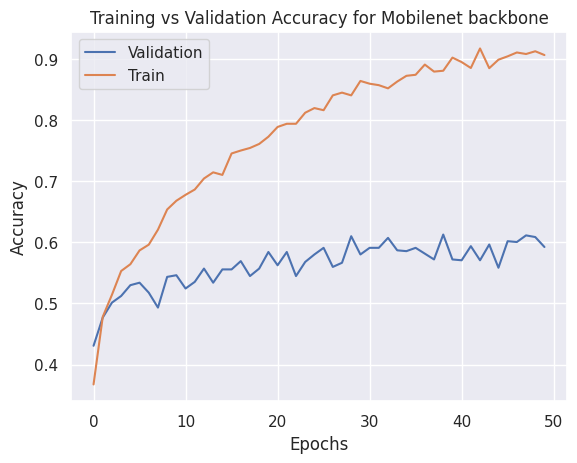

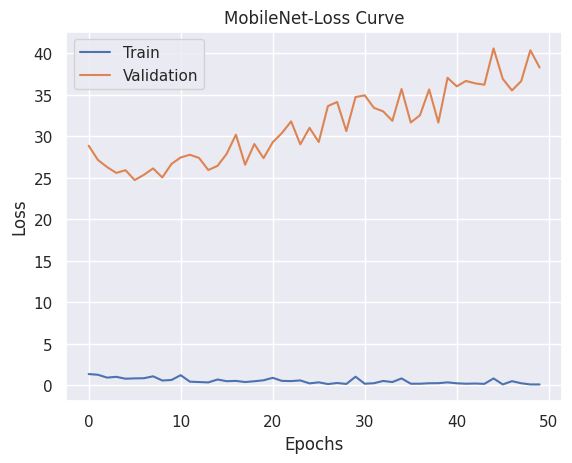

In [23]:
import seaborn as sns
sns.set_theme()
plt.plot(mobilenet_val_acc,label="Validation")
plt.plot(mobilenet_train_acc,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy for Mobilenet backbone")
plt.savefig("plots/mobilenet_train_vs_validation_acc.png")
plt.show()

plt.figure()
plt.plot(mobilenet_loss_with_epochs,label="Train")
plt.plot(mobilenet_val_loss_with_epochs,label="Validation")
plt.title("MobileNet-Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("plots/mobilenet_train_vs_val_loss.png")
plt.show()

# Training VGG16 model

In [42]:
device="cuda"
vgg16_model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
vgg16_model.features[0]=torch.nn.Conv2d(1,64,kernel_size=3,padding=1,stride=1)
vgg_in_features = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = torch.nn.Linear(vgg_in_features,4)
vgg_optimizer = torch.optim.Adam(vgg16_model.parameters(),lr=0.0001,betas=(0.9,0.99),amsgrad=False)
vgg16_train_acc,vgg16_val_acc,vgg16_model,vgg16_loss_with_epochs,vgg16_val_loss_with_epochs = train_evaluate(vgg16_model,vgg_optimizer,train_loader,val_loader,num_epochs=50,save_model_name="vgg16model.pt",dropout=0.5,learning_rate=0.0001,device=device)



Epoch:  1 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.3632  val_acc: 0.3492
Model successfully saved.
Best validation accuracy so far:  0.3492

Epoch:  2 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.4601  val_acc: 0.3098
Best validation accuracy so far:  0.3492

Epoch:  3 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.4799  val_acc: 0.428
Model successfully saved.
Best validation accuracy so far:  0.428

Epoch:  4 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.4646  val_acc: 0.5543
Model successfully saved.
Best validation accuracy so far:  0.5543

Epoch:  5 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5309  val_acc: 0.5258
Best validation accuracy so far:  0.5543

Epoch:  6 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5566  val_acc: 0.4959
Best validation accuracy so far:  0.5543

Epoch:  7 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5576  val_acc: 0.5408
Best validation accuracy so far:  0.5543

Epoch:  8 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5677  val_acc: 0.5761
Model successfully saved.
Best validation accuracy so far:  0.5761

Epoch:  9 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5951  val_acc: 0.5516
Best validation accuracy so far:  0.5761

Epoch:  10 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6073  val_acc: 0.5448
Best validation accuracy so far:  0.5761

Epoch:  11 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6042  val_acc: 0.534
Best validation accuracy so far:  0.5761

Epoch:  12 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6156  val_acc: 0.5598
Best validation accuracy so far:  0.5761

Epoch:  13 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6392  val_acc: 0.5707
Best validation accuracy so far:  0.5761

Epoch:  14 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6396  val_acc: 0.5856
Model successfully saved.
Best validation accuracy so far:  0.5856

Epoch:  15 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6448  val_acc: 0.5516
Best validation accuracy so far:  0.5856

Epoch:  16 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6594  val_acc: 0.6033
Model successfully saved.
Best validation accuracy so far:  0.6033

Epoch:  17 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6632  val_acc: 0.5299
Best validation accuracy so far:  0.6033

Epoch:  18 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6729  val_acc: 0.5707
Best validation accuracy so far:  0.6033

Epoch:  19 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6955  val_acc: 0.5571
Best validation accuracy so far:  0.6033

Epoch:  20 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7014  val_acc: 0.5842
Best validation accuracy so far:  0.6033

Epoch:  21 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6931  val_acc: 0.6209
Model successfully saved.
Best validation accuracy so far:  0.6209

Epoch:  22 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7219  val_acc: 0.5761
Best validation accuracy so far:  0.6209

Epoch:  23 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7212  val_acc: 0.5978
Best validation accuracy so far:  0.6209

Epoch:  24 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7469  val_acc: 0.591
Best validation accuracy so far:  0.6209

Epoch:  25 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7323  val_acc: 0.6046
Best validation accuracy so far:  0.6209

Epoch:  26 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7649  val_acc: 0.6128
Best validation accuracy so far:  0.6209

Epoch:  27 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7792  val_acc: 0.6101
Best validation accuracy so far:  0.6209

Epoch:  28 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8049  val_acc: 0.6087
Best validation accuracy so far:  0.6209

Epoch:  29 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8  val_acc: 0.5815
Best validation accuracy so far:  0.6209

Epoch:  30 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.7847  val_acc: 0.6223
Model successfully saved.
Best validation accuracy so far:  0.6223

Epoch:  31 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8069  val_acc: 0.6196
Best validation accuracy so far:  0.6223

Epoch:  32 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.834  val_acc: 0.5992
Best validation accuracy so far:  0.6223

Epoch:  33 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8226  val_acc: 0.6277
Model successfully saved.
Best validation accuracy so far:  0.6277

Epoch:  34 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8413  val_acc: 0.6332
Model successfully saved.
Best validation accuracy so far:  0.6332

Epoch:  35 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8514  val_acc: 0.6141
Best validation accuracy so far:  0.6332

Epoch:  36 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8361  val_acc: 0.606
Best validation accuracy so far:  0.6332

Epoch:  37 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8674  val_acc: 0.5992
Best validation accuracy so far:  0.6332

Epoch:  38 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8872  val_acc: 0.5978
Best validation accuracy so far:  0.6332

Epoch:  39 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8792  val_acc: 0.6291
Best validation accuracy so far:  0.6332

Epoch:  40 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8778  val_acc: 0.6155
Best validation accuracy so far:  0.6332

Epoch:  41 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8726  val_acc: 0.6264
Best validation accuracy so far:  0.6332

Epoch:  42 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8944  val_acc: 0.5883
Best validation accuracy so far:  0.6332

Epoch:  43 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8958  val_acc: 0.6413
Model successfully saved.
Best validation accuracy so far:  0.6413

Epoch:  44 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8903  val_acc: 0.6236
Best validation accuracy so far:  0.6413

Epoch:  45 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8948  val_acc: 0.5965
Best validation accuracy so far:  0.6413

Epoch:  46 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.9083  val_acc: 0.6495
Model successfully saved.
Best validation accuracy so far:  0.6495

Epoch:  47 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.901  val_acc: 0.6073
Best validation accuracy so far:  0.6495

Epoch:  48 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.9028  val_acc: 0.6019
Best validation accuracy so far:  0.6495

Epoch:  49 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.9132  val_acc: 0.5965
Best validation accuracy so far:  0.6495

Epoch:  50 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.8927  val_acc: 0.6141
Best validation accuracy so far:  0.6495


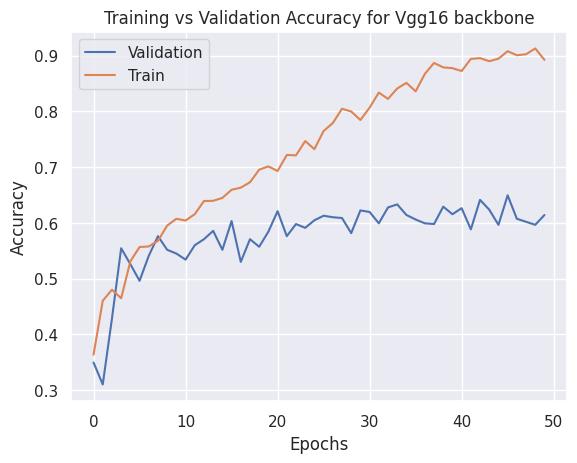

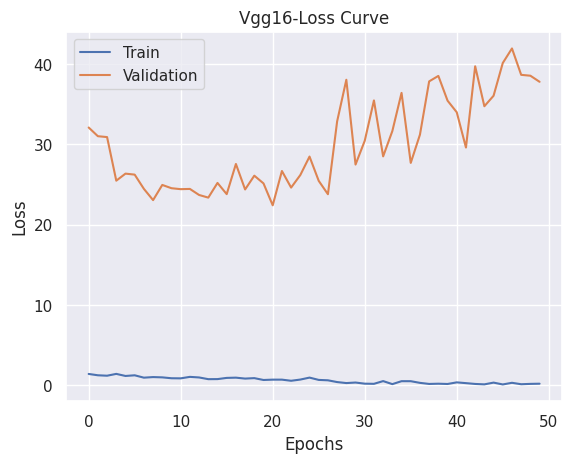

In [44]:
plt.figure()
plt.plot(vgg16_val_acc,label="Validation")
plt.plot(vgg16_train_acc,label="Train")
plt.legend()
plt.title("Training vs Validation Accuracy for Vgg16 backbone")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("plots/Vgg16_train_vs_validation_acc.png")

plt.figure()
plt.plot(vgg16_loss_with_epochs,label="Train")
plt.plot(vgg16_val_loss_with_epochs,label="Validation")
plt.title("Vgg16-Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("plots/Vgg16_train_vs_val_loss.png")

# Training Hybrid CNN-RNN Model

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = RModel()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,betas=(0.99,0.99),amsgrad=False)
train_acc,val_acc,model,loss_with_epochs,val_loss_with_epochs = train_evaluate(model,optimizer,train_loader,val_loader,num_epochs=50,save_model_name="model.pt",dropout=0.5,learning_rate=0.0001,device=device)



Epoch:  1 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

/home/user/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/.local/lib/python3.8/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train_acc: 0.3684  val_acc: 0.197
Model saved at model.pt
Best train loss: 0.043451348774962956

Epoch:  2 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.1844  val_acc: 0.2989
Model saved at model.pt
Best train loss: 0.043191096641951136

Epoch:  3 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.4174  val_acc: 0.4579
Model saved at model.pt
Best train loss: 0.042652966247664556

Epoch:  4 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.4892  val_acc: 0.4552
Model saved at model.pt
Best train loss: 0.04198171935147709

Epoch:  5 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.466  val_acc: 0.4565
Model saved at model.pt
Best train loss: 0.04190903575056129

Epoch:  6 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.4288  val_acc: 0.4633
Model saved at model.pt
Best train loss: 0.041439861555894214

Epoch:  7 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5052  val_acc: 0.4443
Model saved at model.pt
Best train loss: 0.0412632666528225

Epoch:  8 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.4757  val_acc: 0.4823
Model saved at model.pt
Best train loss: 0.04104222841560841

Epoch:  9 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.4913  val_acc: 0.462

Epoch:  10 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.4885  val_acc: 0.4837
Model saved at model.pt
Best train loss: 0.04056486404604382

Epoch:  11 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5292  val_acc: 0.4932
Model saved at model.pt
Best train loss: 0.04044623072776529

Epoch:  12 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5149  val_acc: 0.4837
Model saved at model.pt
Best train loss: 0.04034519721236494

Epoch:  13 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5264  val_acc: 0.466

Epoch:  14 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5  val_acc: 0.4905

Epoch:  15 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5292  val_acc: 0.4932
Model saved at model.pt
Best train loss: 0.04017679004205598

Epoch:  16 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5056  val_acc: 0.4565
Model saved at model.pt
Best train loss: 0.04010945161183675

Epoch:  17 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5188  val_acc: 0.4579

Epoch:  18 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.4865  val_acc: 0.4905
Model saved at model.pt
Best train loss: 0.03995533953938219

Epoch:  19 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5167  val_acc: 0.4334

Epoch:  20 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5413  val_acc: 0.4647
Model saved at model.pt
Best train loss: 0.039809573690096536

Epoch:  21 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.517  val_acc: 0.5177
Model saved at model.pt
Best train loss: 0.03979449694355329

Epoch:  22 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5205  val_acc: 0.4701
Model saved at model.pt
Best train loss: 0.0396340540299813

Epoch:  23 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5167  val_acc: 0.4742
Model saved at model.pt
Best train loss: 0.03937194090750482

Epoch:  24 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5385  val_acc: 0.4511
Model saved at model.pt
Best train loss: 0.039174870567189324

Epoch:  25 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5347  val_acc: 0.4918
Model saved at model.pt
Best train loss: 0.039075749160514935

Epoch:  26 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5372  val_acc: 0.4837

Epoch:  27 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5497  val_acc: 0.5109
Model saved at model.pt
Best train loss: 0.03896022347940339

Epoch:  28 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5347  val_acc: 0.4837

Epoch:  29 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5413  val_acc: 0.462
Model saved at model.pt
Best train loss: 0.038870409917500286

Epoch:  30 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5344  val_acc: 0.4986
Model saved at model.pt
Best train loss: 0.03855257373717096

Epoch:  31 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5479  val_acc: 0.466
Model saved at model.pt
Best train loss: 0.03842390175494883

Epoch:  32 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.559  val_acc: 0.5
Model saved at model.pt
Best train loss: 0.038277861517336635

Epoch:  33 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5611  val_acc: 0.4783
Model saved at model.pt
Best train loss: 0.038257581326696606

Epoch:  34 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5552  val_acc: 0.4783

Epoch:  35 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5698  val_acc: 0.4905
Model saved at model.pt
Best train loss: 0.03806635994050238

Epoch:  36 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5389  val_acc: 0.4918
Model saved at model.pt
Best train loss: 0.03798615725504027

Epoch:  37 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5622  val_acc: 0.5109
Model saved at model.pt
Best train loss: 0.03786150018374125

Epoch:  38 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5788  val_acc: 0.5109
Model saved at model.pt
Best train loss: 0.03756985391179721

Epoch:  39 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5542  val_acc: 0.4946

Epoch:  40 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.575  val_acc: 0.4959
Model saved at model.pt
Best train loss: 0.03747605143321885

Epoch:  41 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5552  val_acc: 0.5122

Epoch:  42 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5778  val_acc: 0.4986

Epoch:  43 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5778  val_acc: 0.5041
Model saved at model.pt
Best train loss: 0.0372897296730015

Epoch:  44 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5701  val_acc: 0.5
Model saved at model.pt
Best train loss: 0.037227122257981034

Epoch:  45 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5753  val_acc: 0.5299
Model saved at model.pt
Best train loss: 0.03704658111350404

Epoch:  46 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5747  val_acc: 0.5149
Model saved at model.pt
Best train loss: 0.03699542838666174

Epoch:  47 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5861  val_acc: 0.4701

Epoch:  48 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.5701  val_acc: 0.5245
Model saved at model.pt
Best train loss: 0.036976549836496515

Epoch:  49 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6014  val_acc: 0.5082
Model saved at model.pt
Best train loss: 0.03653493022753133

Epoch:  50 / 50


  0%|          | 0/90 [00:00<?, ?it/s]

train_acc: 0.6017  val_acc: 0.5027
Model saved at model.pt
Best train loss: 0.03646533033914036


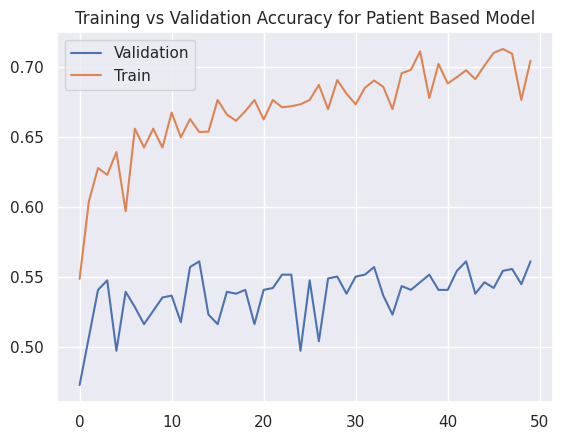

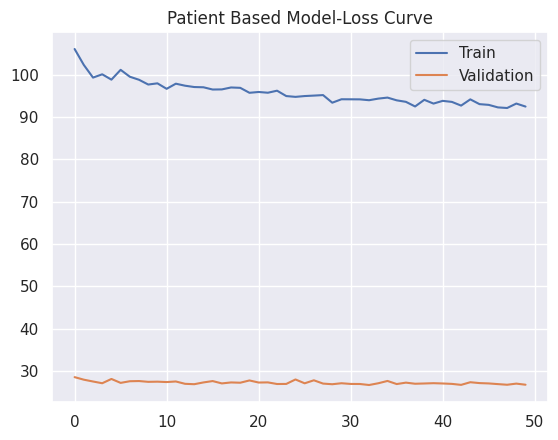

In [62]:
import seaborn as sns
sns.set_theme()
plt.figure()
plt.plot(val_acc,label="Validation")
plt.plot(train_acc,label="Train")
plt.legend()
plt.title("Training vs Validation Accuracy for Patient Based Model")
plt.savefig("plots/patient_based_model_train_vs_validation_acc.png")
plt.show()

plt.figure()
plt.plot(loss_with_epochs,label="Train")
plt.plot(val_loss_with_epochs,label="Validation")
plt.title("Patient Based Model-Loss Curve")
plt.legend()
plt.savefig("plots/patient_based_model_train_vs_val_loss.png")
plt.show()

## Fine tune the patient based model for a particular patient

In [41]:
patient_wise_tune_data = train_dataset.dataset.patient_to_idx
# patient to samples is a dict containing patient id as key and list of samples as value
# we need to fine tune the model patient wise
# we will use the same model as before

patient_id = "107"
patient_samples = patient_wise_tune_data[patient_id]
patient_train_samples = patient_samples[:int(0.8*len(patient_samples))]
patient_test_samples = patient_samples[int(0.8*len(patient_samples)):]
patient_train_dataset = torch.utils.data.Subset(train_dataset,patient_train_samples)
patient_test_dataset = torch.utils.data.Subset(train_dataset,patient_test_samples)
patient_train_loader = torch.utils.data.DataLoader(patient_train_dataset,batch_size=32,shuffle=True)
patient_test_loader = torch.utils.data.DataLoader(patient_test_dataset,batch_size=32,shuffle=True)



In [66]:
fine_tune_optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,betas=(0.9,0.99),amsgrad=False,weight_decay=0.0001)
fine_tune_train_acc,fine_tune_val_acc,fine_tune_model,fine_tune_loss_with_epochs,fine_tune_val_loss_with_epochs = train_evaluate(model,fine_tune_optimizer,patient_train_loader,patient_test_loader,num_epochs=200,save_model_name="fine_tune_model.pt",dropout=0.5,learning_rate=0.0001,device=device)


Epoch:  1 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.4688  val_acc: 0.1562
Model saved at fine_tune_model.pt
Best train loss: 0.03227902576327324

Epoch:  2 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5  val_acc: 0.1562

Epoch:  3 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5  val_acc: 0.125

Epoch:  4 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5  val_acc: 0.1562

Epoch:  5 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5312  val_acc: 0.1562

Epoch:  6 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.4688  val_acc: 0.125

Epoch:  7 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5625  val_acc: 0.1562
Model saved at fine_tune_model.pt
Best train loss: 0.02950633130967617

Epoch:  8 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5  val_acc: 0.1562

Epoch:  9 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.625  val_acc: 0.1562

Epoch:  10 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5  val_acc: 0.1562

Epoch:  11 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5312  val_acc: 0.1562

Epoch:  12 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562
Model saved at fine_tune_model.pt
Best train loss: 0.02650471217930317

Epoch:  13 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5938  val_acc: 0.1875

Epoch:  14 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5625  val_acc: 0.1562

Epoch:  15 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5938  val_acc: 0.1562

Epoch:  16 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5625  val_acc: 0.1562

Epoch:  17 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5938  val_acc: 0.1562

Epoch:  18 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5938  val_acc: 0.1562

Epoch:  19 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5938  val_acc: 0.125

Epoch:  20 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.625  val_acc: 0.1562

Epoch:  21 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5938  val_acc: 0.1562

Epoch:  22 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5938  val_acc: 0.1562

Epoch:  23 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1875
Model saved at fine_tune_model.pt
Best train loss: 0.024095682427287102

Epoch:  24 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  25 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.625  val_acc: 0.1562

Epoch:  26 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.625  val_acc: 0.1875

Epoch:  27 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.625  val_acc: 0.0938

Epoch:  28 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  29 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5938  val_acc: 0.125

Epoch:  30 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5625  val_acc: 0.125

Epoch:  31 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.625  val_acc: 0.125

Epoch:  32 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  33 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125
Model saved at fine_tune_model.pt
Best train loss: 0.023669620975852013

Epoch:  34 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  35 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  36 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  37 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  38 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.625  val_acc: 0.125

Epoch:  39 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  40 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  41 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  42 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562
Model saved at fine_tune_model.pt
Best train loss: 0.023312171921133995

Epoch:  43 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.625  val_acc: 0.125

Epoch:  44 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.5625  val_acc: 0.1562

Epoch:  45 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562
Model saved at fine_tune_model.pt
Best train loss: 0.02330363541841507

Epoch:  46 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.625  val_acc: 0.1562

Epoch:  47 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.625  val_acc: 0.1562

Epoch:  48 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  49 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  50 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.625  val_acc: 0.1562

Epoch:  51 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  52 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562
Model saved at fine_tune_model.pt
Best train loss: 0.023277057334780693

Epoch:  53 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  54 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.625  val_acc: 0.1562

Epoch:  55 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.625  val_acc: 0.125

Epoch:  56 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  57 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  58 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  59 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562
Model saved at fine_tune_model.pt
Best train loss: 0.02327299676835537

Epoch:  60 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  61 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125
Model saved at fine_tune_model.pt
Best train loss: 0.023245958611369133

Epoch:  62 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  63 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  64 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  65 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  66 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  67 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.625  val_acc: 0.125

Epoch:  68 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  69 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  70 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.0938

Epoch:  71 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562
Model saved at fine_tune_model.pt
Best train loss: 0.023243561387062073

Epoch:  72 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  73 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  74 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  75 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  76 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  77 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  78 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.0938

Epoch:  79 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.0938

Epoch:  80 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  81 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  82 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  83 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  84 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  85 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  86 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  87 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  88 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  89 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  90 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  91 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  92 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1875

Epoch:  93 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  94 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.0938

Epoch:  95 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  96 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  97 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  98 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  99 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1875

Epoch:  100 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  101 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  102 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  103 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1875
Model saved at fine_tune_model.pt
Best train loss: 0.023241236805915833

Epoch:  104 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  105 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  106 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  107 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1875

Epoch:  108 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  109 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  110 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  111 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  112 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  113 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.0938

Epoch:  114 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  115 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  116 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125
Model saved at fine_tune_model.pt
Best train loss: 0.02324122004210949

Epoch:  117 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  118 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  119 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1875

Epoch:  120 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  121 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  122 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562
Model saved at fine_tune_model.pt
Best train loss: 0.023240016773343086

Epoch:  123 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  124 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  125 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  126 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.0938

Epoch:  127 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  128 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  129 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  130 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  131 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  132 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  133 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  134 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  135 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  136 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  137 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  138 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  139 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  140 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  141 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  142 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  143 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125
Model saved at fine_tune_model.pt
Best train loss: 0.02323981188237667

Epoch:  144 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  145 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  146 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  147 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  148 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  149 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  150 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  151 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  152 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  153 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  154 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  155 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  156 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.0938

Epoch:  157 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  158 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  159 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  160 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  161 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  162 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  163 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  164 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  165 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  166 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  167 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  168 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  169 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  170 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  171 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  172 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  173 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  174 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  175 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.0938

Epoch:  176 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  177 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  178 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  179 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  180 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  181 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  182 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  183 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  184 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  185 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  186 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  187 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  188 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.0938

Epoch:  189 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  190 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  191 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  192 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.1562

Epoch:  193 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.0938

Epoch:  194 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.1562

Epoch:  195 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  196 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  197 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6562  val_acc: 0.125

Epoch:  198 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125

Epoch:  199 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.0938

Epoch:  200 / 200


  0%|          | 0/1 [00:00<?, ?it/s]

train_acc: 0.6875  val_acc: 0.125


# Results

In [60]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
# load the saved models for direct testing
# fine_tune_model = RModel()
# fine_tune_model.load_state_dict(torch.load("saved_models/fine_tune_model.pt"))
# fine_tune_model = fine_tune_model.to(device)


In [63]:
# load the saved models for direct testing
# vgg16_model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
# vgg16_model.features[0]=torch.nn.Conv2d(1,64,kernel_size=3,padding=1,stride=1)
# vgg_in_features = vgg16_model.classifier[6].in_features
# vgg16_model.classifier[6] = torch.nn.Linear(vgg_in_features,4)

# vgg16_model.load_state_dict(torch.load("saved_models/vgg16model.pt"))
# vgg16_model = vgg16_model.to(device)

In [64]:
# load the saved models for direct testing
# mobilenet_model = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights)
# new_conv = torch.nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
# # with torch.no_grad():
# #     new_conv.weight[:, 0, :, :] = mobilenet_model.features[0].weight.sum(dim=1)
# mobilenet_model.features[0] = new_conv
# mobilenet_in_features = mobilenet_model.classifier[1].in_features
# mobilenet_model.classifier[1] = torch.nn.Linear(mobilenet_in_features,4)
# mobilenet_model.load_state_dict(torch.load("saved_models/mobilenetmodel.pt"))
# mobilenet_model = mobilenet_model.to(device)

In [61]:
print("Results on Testing Data")
loss,specificity, sensitivity, score = get_scores(fine_tune_model, test_loader, device)
print("Test Loss on fine tuned patient specific model: ",loss)
print("Test Specificity on fine tuned patient specific model: ",specificity*100)
print("Test Sensitivity on fine tuned patient specific model: ",sensitivity*100)
print("Test Score on fine tuned patient specific model: ",score*100)


Results on Testing Data
Test Loss on fine tuned patient specific model:  0.04004629256824652
Test Specificity on fine tuned patient specific model:  44.53571428571429
Test Sensitivity on fine tuned patient specific model:  51.900456964203066
Test Score on fine tuned patient specific model:  48.21808562495869


In [88]:
print("Results on Testing Data")
loss,specificity, sensitivity, score = get_scores(vgg16_model, test_loader, device)
print("Test Loss on fine tuned Vgg16 backbone model: ",loss)
print("Test Specificity on fine tuned Vgg16 backbone model: ",specificity)
print("Test Sensitivity on fine tuned Vgg16 backbone model: ",sensitivity)
print("Test Score on fine tuned Vgg16 backbone model: ",score)


Results on Testing Data
Test Loss on fine tuned Vgg16 backbone model:  0.04184153482317925
Test Specificity on fine tuned Vgg16 backbone model:  0.40113095238095237
Test Sensitivity on fine tuned Vgg16 backbone model:  0.39370972396931464
Test Score on fine tuned Vgg16 backbone model:  0.3974203381751336


In [91]:
print("Results on Testing Data")
loss,specificity, sensitivity, score = get_scores(mobilenet_model, test_loader, device)
print("Test Loss on fine tuned Mobilenet backbone model: ",loss)
print("Test Specificity on fine tuned Mobilenet backbone model: ",specificity)
print("Test Sensitivity on fine tuned Mobilenet backbone model: ",sensitivity)
print("Test Score on fine tuned Mobilenet backbone model: ",score)


Results on Testing Data
Test Loss on fine tuned Mobilenet backbone model:  0.07910254761576653
Test Specificity on fine tuned Mobilenet backbone model:  0.4244642857142857
Test Sensitivity on fine tuned Mobilenet backbone model:  0.5070550929694287
Test Score on fine tuned Mobilenet backbone model:  0.4657596893418574


In [73]:
print("Results on patient 107 using fine tuned patient specific model")
loss,specificity, sensitivity, score = get_scores(fine_tune_model, patient_test_loader, device)
print("Test Loss for patient 107 on fine tuned patient specific model: ",loss)
print("Test Specificity for patient 107 on fine tuned patient specific model: ",specificity*100)
print("Test Sensitivity for patient 107 on fine tuned patient specific model: ",sensitivity*100)
print("Test Score for patient 107 on fine tuned patient specific model: ",score*100)
print("-------------------------------------------")
print("Results on patient 107 using fine tuned Vgg16 backbone model")
loss,specificity, sensitivity, score = get_scores(vgg16_model, patient_test_loader, device)
print("Test Loss for patient 107 on fine tuned Vgg16 backbone model: ",loss)
print("Test Specificity for patient 107 on fine tuned Vgg16 backbone model: ",specificity*100)
print("Test Sensitivity for patient 107 on fine tuned Vgg16 backbone model: ",sensitivity*100)
print("Test Score for patient 107 on fine tuned Vgg16 backbone model: ",score*100)
print("-------------------------------------------")
print("Results on patient 107 using fine tuned Mobilenet backbone model")
loss,specificity, sensitivity, score = get_scores(mobilenet_model, patient_test_loader, device)
print("Test Loss for patient 107 on fine tuned Mobilenet backbone model: ",loss)
print("Test Specificity for patient 107 on fine tuned Mobilenet backbone model: ",specificity*100)
print("Test Sensitivity for patient 107 on fine tuned Mobilenet backbone model: ",sensitivity*100)
print("Test Score for patient 107 on fine tuned Mobilenet backbone model: ",score*100)
print("-------------------------------------------")


Results on patient 107 using fine tuned patient specific model
Test Loss for patient 107 on fine tuned patient specific model:  0.0010429327376186848
Test Specificity for patient 107 on fine tuned patient specific model:  100.0
Test Sensitivity for patient 107 on fine tuned patient specific model:  100.0
Test Score for patient 107 on fine tuned patient specific model:  100.0
-------------------------------------------
Results on patient 107 using fine tuned Vgg16 backbone model
Test Loss for patient 107 on fine tuned Vgg16 backbone model:  0.03787274658679962
Test Specificity for patient 107 on fine tuned Vgg16 backbone model:  50.0
Test Sensitivity for patient 107 on fine tuned Vgg16 backbone model:  100.0
Test Score for patient 107 on fine tuned Vgg16 backbone model:  75.0
-------------------------------------------
Results on patient 107 using fine tuned Mobilenet backbone model
Test Loss for patient 107 on fine tuned Mobilenet backbone model:  0.006522719282656908
Test Specificity 

In [101]:
# print model summary
import torchsummary
print("Patient Based Model Summary")
torchsummary.summary(fine_tune_model,(1,256,256))



Patient Based Model Summary
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 24, 3]          --
|    └─BatchNorm2d: 2-1                  [-1, 1, 256, 256]         2
|    └─Conv2d: 2-2                       [-1, 64, 252, 250]        2,304
|    └─ReLU: 2-3                         [-1, 64, 252, 250]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 126, 83]         --
|    └─Conv2d: 2-5                       [-1, 64, 124, 81]         36,928
|    └─ReLU: 2-6                         [-1, 64, 124, 81]         --
|    └─Conv2d: 2-7                       [-1, 64, 122, 79]         36,928
|    └─ReLU: 2-8                         [-1, 64, 122, 79]         --
|    └─MaxPool2d: 2-9                    [-1, 64, 61, 26]          --
|    └─Conv2d: 2-10                      [-1, 128, 59, 24]         73,856
|    └─ReLU: 2-11                        [-1, 128, 59, 24]         --
|    └─Conv2d: 2-12                      [-

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 24, 3]          --
|    └─BatchNorm2d: 2-1                  [-1, 1, 256, 256]         2
|    └─Conv2d: 2-2                       [-1, 64, 252, 250]        2,304
|    └─ReLU: 2-3                         [-1, 64, 252, 250]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 126, 83]         --
|    └─Conv2d: 2-5                       [-1, 64, 124, 81]         36,928
|    └─ReLU: 2-6                         [-1, 64, 124, 81]         --
|    └─Conv2d: 2-7                       [-1, 64, 122, 79]         36,928
|    └─ReLU: 2-8                         [-1, 64, 122, 79]         --
|    └─MaxPool2d: 2-9                    [-1, 64, 61, 26]          --
|    └─Conv2d: 2-10                      [-1, 128, 59, 24]         73,856
|    └─ReLU: 2-11                        [-1, 128, 59, 24]         --
|    └─Conv2d: 2-12                      [-1, 128, 57, 22]         147,

In [102]:
print("MobileNet Model Summary")
torchsummary.summary(mobilenet_model,(1,256,256))


MobileNet Model Summary
Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1280, 8, 8]          --
|    └─Conv2d: 2-1                                 [-1, 32, 128, 128]        288
|    └─InvertedResidual: 2-2                       [-1, 16, 128, 128]        --
|    |    └─Sequential: 3-1                        [-1, 16, 128, 128]        896
|    └─InvertedResidual: 2-3                       [-1, 24, 64, 64]          --
|    |    └─Sequential: 3-2                        [-1, 24, 64, 64]          5,136
|    └─InvertedResidual: 2-4                       [-1, 24, 64, 64]          --
|    |    └─Sequential: 3-3                        [-1, 24, 64, 64]          8,832
|    └─InvertedResidual: 2-5                       [-1, 32, 32, 32]          --
|    |    └─Sequential: 3-4                        [-1, 32, 32, 32]          10,000
|    └─InvertedResidual: 2-6                       [-1, 32, 32, 32]          --

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1280, 8, 8]          --
|    └─Conv2d: 2-1                                 [-1, 32, 128, 128]        288
|    └─InvertedResidual: 2-2                       [-1, 16, 128, 128]        --
|    |    └─Sequential: 3-1                        [-1, 16, 128, 128]        896
|    └─InvertedResidual: 2-3                       [-1, 24, 64, 64]          --
|    |    └─Sequential: 3-2                        [-1, 24, 64, 64]          5,136
|    └─InvertedResidual: 2-4                       [-1, 24, 64, 64]          --
|    |    └─Sequential: 3-3                        [-1, 24, 64, 64]          8,832
|    └─InvertedResidual: 2-5                       [-1, 32, 32, 32]          --
|    |    └─Sequential: 3-4                        [-1, 32, 32, 32]          10,000
|    └─InvertedResidual: 2-6                       [-1, 32, 32, 32]          --
|    |    └─Sequential:

In [103]:
print("Vgg16 Model Summary")
torchsummary.summary(vgg16_model,(1,256,256))

Vgg16 Model Summary
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 8, 8]           --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        640
|    └─ReLU: 2-2                         [-1, 64, 256, 256]        --
|    └─Conv2d: 2-3                       [-1, 64, 256, 256]        36,928
|    └─ReLU: 2-4                         [-1, 64, 256, 256]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 128, 128]        --
|    └─Conv2d: 2-6                       [-1, 128, 128, 128]       73,856
|    └─ReLU: 2-7                         [-1, 128, 128, 128]       --
|    └─Conv2d: 2-8                       [-1, 128, 128, 128]       147,584
|    └─ReLU: 2-9                         [-1, 128, 128, 128]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 64, 64]         --
|    └─Conv2d: 2-11                      [-1, 256, 64, 64]         295,168
|    └─ReLU: 2-12                        [-1, 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 8, 8]           --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        640
|    └─ReLU: 2-2                         [-1, 64, 256, 256]        --
|    └─Conv2d: 2-3                       [-1, 64, 256, 256]        36,928
|    └─ReLU: 2-4                         [-1, 64, 256, 256]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 128, 128]        --
|    └─Conv2d: 2-6                       [-1, 128, 128, 128]       73,856
|    └─ReLU: 2-7                         [-1, 128, 128, 128]       --
|    └─Conv2d: 2-8                       [-1, 128, 128, 128]       147,584
|    └─ReLU: 2-9                         [-1, 128, 128, 128]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 64, 64]         --
|    └─Conv2d: 2-11                      [-1, 256, 64, 64]         295,168
|    └─ReLU: 2-12                        [-1, 256, 64, 64]        